* https://github.com/sooftware/attentions/blob/master/attentions.py - виды Attention
* https://colab.research.google.com/github/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb - sentencepiece tutorial

* https://jonathanbgn.com/2021/08/30/audio-augmentation.html - аугментации
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52 - аугментации

In [ ]:
# !pip install sentencepiece
# !pip install Levenshtein

In [ ]:
import pandas as pd
import numpy as np
import math
import os
import random
import torchaudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import sentencepiece as stp
import librosa
import random
import librosa.display as display
import Levenshtein as Lev 

from torch.autograd import Variable
from tqdm.notebook import tqdm
from typing import Optional, Tuple
from torch.utils.data import Dataset, DataLoader, Sampler
from torchaudio.transforms import Spectrogram, MelSpectrogram
from matplotlib import pyplot as plt
from torch import Tensor

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda:3')# if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=3)

Функции подсчета расстояния и ошибочно распознанных символов

In [ ]:
def distance_batch(y_true, y_pred, eos_id, len_X):
    batch_size = y_true.size(0)
    s = 0
    for i in range(batch_size):
        target = [int(j) for j in y_true[i].cpu().numpy()]
        predict = [int(j) for j in y_pred[i].cpu().numpy()]
        target = target[:target.index(eos_id) + 1]
        try:
            predict = predict[:predict.index(eos_id) + 1]
        except:
            predict = predict[:int(len_X[i] / 3)]
        str_target = tokenizer.decode_ids(target)
        str_predict = tokenizer.decode_ids(predict)
        s += Lev.distance(str_predict, str_target)
    return s

def error_symbols(y_true, y_pred, lengths):
    s = 0
    for i, l in enumerate(lengths):
        s += (y_true[i, :l-1] != y_pred[i, :l-1]).sum()
    return s

In [ ]:
df = pd.read_csv('data/data/train_labels.csv')
df_test = pd.read_csv('data/data/sample_submission.csv')
df_test.set_index('Id', inplace=True)
df.set_index('Id', inplace=True)
df.head()

,Expected
Id,
0,лицо чуть широковатое с круглым и твердым подб...
1,я видел такое о чем не смею рассказать вам отв...
2,я быстро справилась с собой и попала ей в тон
3,заохал демидов
4,тут будут казнить кого то важного по меньшей м...


In [ ]:
# l = os.listdir('data/data/train_wavs')
# list_idx = list(map(lambda x: int(x[:-4]), l))
# df = df.loc[list_idx]
# df = df.iloc[:1000, :]

In [ ]:
from sklearn.model_selection import train_test_split

train_folder = 'data/data/train_wavs'
data = [{'text': df.loc[i].Expected, 'wav': str(i) + '.wav'} for i in df.index.values]
train_data, valid_data = train_test_split(data, train_size=0.9, shuffle=True, random_state = seed)

Конфигурации загрузки 

In [ ]:
data_folder = 'data/data/train_wavs'

audio_load_config = {
    'frame_offset': 0,       # by default 0
    'num_frames': -1,        # by default -1
    'normalize': False,      # by default True
    'channels_first': True,   # by default True
}

mespectr_config = {
    'sample_rate': 16000,
    'n_fft': 4096,         
    'win_length': 4096,   
    'hop_length': 1024,    
    'f_min': 0.0,
    'f_max': None,
    'pad': 0,
    'n_mels': 128,         # count of filters
    'window_fn': torch.hann_window,
    'power': 2,            # 1-energy, 2-power
    'normalized': False,
    'wkwargs': None,
    'center': True,
    'pad_mode': 'reflect',
    'onesided': True,
    'norm': None, 
#     'mel_scale': 'htk'        
} 

In [ ]:
# path = 'data/data/train_wavs/12730.wav'
# audio, sr = torchaudio.load(path, **audio_load_config)
# Melspectr = MelSpectrogram(**mespectr_config)
# spectr = Melspectr(audio.to(torch.FloatTensor()))
# db_Melspectr = torchaudio.transforms.AmplitudeToDB()
# db_spectr = db_Melspectr(spectr)
# plt.figure(figsize = (12, 8))
# plt.imshow(db_spectr.squeeze().numpy())
# plt.show()

Класс расчета вектора-статистик по мел спектрограмме, для нормировки


In [ ]:
class Stats:
    def __init__(self, data_folder, data_list, audio_load_config, mespectr_config):
        self.size = len(data_list)
        self.data_list = data_list
        self.data_folder = data_folder
        self.audio_load_config = audio_load_config
        self.mean_vector = None
        self.std_vector = None
        self.mean_scalar = None
        self.std_scalar = None
        self.melspectr = MelSpectrogram(**mespectr_config)
        

    def __get_mell_spect(self, file_name) -> torch.Tensor:
        full_path = os.path.join(self.data_folder, file_name)
        audio, sample_rate = torchaudio.load(full_path, **self.audio_load_config)
        spectr = self.melspectr(audio.to(torch.FloatTensor()))
        return spectr
            
            
    def __calculate_mean_vector(self): 
        sum_all = torch.zeros(self.melspectr.n_mels)
        for el in tqdm(self.data_list):
            mel_spect = self.__get_mell_spect(el['wav'])
            mel_spect = torch.log1p(mel_spect)
            sum_all += mel_spect[0].mean(axis = 1)
        self.mean_vector = (sum_all / self.size).reshape(-1, 1)

    def __calculate_std_vector(self):
        std_all = torch.zeros(self.melspectr.n_mels)
        for el in tqdm(self.data_list):
            mel_spect = self.__get_mell_spect(el['wav'])
            mel_spect = torch.log1p(mel_spect)
            std_all += mel_spect[0].std(axis = 1)
        self.std_vector = (std_all / self.size).reshape(-1, 1)      
    

    def vector_stats(self):
        if self.mean_vector is None:
            self.__calculate_mean_vector()
        if self.std_vector is None:
            self.__calculate_std_vector()
        return self.mean_vector, self.std_vector
    

In [ ]:
# data_folder = 'data/data/train_wavs'
# list_dir = os.listdir(data_folder)
# train = [{'wav':name} for name in list_dir]
stats = Stats(data_folder=data_folder, data_list=train_data, audio_load_config = audio_load_config,
              mespectr_config= mespectr_config)

In [ ]:
# means, stds = stats.vector_stats()
# my_stats = {'mean': means, 'std': stds}
# torch.save(my_stats, 'stats.pt')
my_stats = torch.load('stats.pt')

Записываю фразы в файл, на нем будет учиться словарь

In [ ]:
def write_file(data_dict, write=True):
    string = ''
    for el in tqdm(data_dict):
        string += el['text'] + '\n'
    if write:
        with open('text.txt', 'w') as file:
            file.write(string) 
    return string
  

In [ ]:
# f1 = write_file(train_data)

# stp.SentencePieceTrainer.train('--input=text.txt\
#                                --model_prefix=m_unigram_1000\
#                                --vocab_size=1000\
#                                --model_type=unigram\
#                                --character_coverage=1.0')  # --character_coverage=0.9995

tokenizer = stp.SentencePieceProcessor()
tokenizer.load('m_unigram_1000.model')

True

Класс аугментации

In [ ]:
class WavAugmentation():
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate
    
    def __call__(self, audio_data):
        speed_factor = np.random.uniform(0.85, 1.15)
        pitch_factor = np.random.uniform(-200, 200)
        gain_factor = np.random.uniform(-0.2, 0.2)
        
        
        sox_effects = [
            ['gain', str(gain_factor)],  # normalises to 0dB
            ['pitch', str(pitch_factor)],
            ["speed", str(speed_factor)],
            ["rate", str(self.sample_rate)],
        ]
        transformed_audio, _ = torchaudio.sox_effects.apply_effects_tensor(
            audio_data, self.sample_rate, sox_effects)
        return transformed_audio

In [ ]:
class SpectrogramDataset(Dataset):
    def __init__(self, data_folder: str, data_list: dict, audio_load_config: set, mespectr_config: set, 
           tokenizer:stp.SentencePieceTrainer, stats: dict = None, use_augmentation: bool=True) -> None:
        super(SpectrogramDataset, self).__init__()
        
        self.data_folder = data_folder
        self.data_list = data_list
        self.size = len(self.data_list)
        self.audio_load_config = audio_load_config
        self.melspectr = MelSpectrogram(**mespectr_config)
        self.tokenizer = tokenizer
        self.stats = stats
        self.wav_augmentation = WavAugmentation(mespectr_config['sample_rate'])
        self.use_augmentation = use_augmentation

            
    def __getitem__(self, index: int) -> Tuple[Tensor, Tensor]:
        wav_name = self.data_list[index]['wav']
        transcript = self.data_list[index]['text']
        audio_path = os.path.join(self.data_folder, wav_name)
        spect = self.parse_audio(audio_path)
        transcript = self.parse_transcript(transcript)
        return spect, transcript
    
    def parse_audio(self, audio_path: str) -> Tensor:
        audio, sr = torchaudio.load(audio_path, **self.audio_load_config)
        if self.use_augmentation:
            audio = self.wav_augmentation(audio)
        spect = self.melspectr(audio.to(torch.FloatTensor()))
        spect = torch.log1p(spect)
        if self.stats is not None:
            spect -= self.stats['mean']
            spect /= self.stats['std']
        return spect
    
    def parse_transcript(self, transcript) -> Tensor:
        transcript = self.tokenizer.encode_as_ids(transcript)   
        transcript.insert(0, self.tokenizer.bos_id())
        transcript.append(self.tokenizer.eos_id())
        return transcript

    def __len__(self) -> int:
        return self.size
    
  
def _collate_fn(batch):
    def seq_length_(p):
        return p[0].size(1)
    def target_length_(p):
        return len(p[1]) 
    
    batch = sorted(batch, key=lambda sample: sample[0].size(2), reverse=True) # сортировка для упаковки rnn 
    seq_lengths = [s[0].size(2) for s in batch]
    target_lengths = [len(s[1]) for s in batch]
    max_seq_size = max(seq_lengths)
    max_target_size = max(target_lengths)

    feat_size = batch[0][0].size(1)
    batch_size = len(batch)

    seqs = torch.zeros(batch_size, 1, feat_size, max_seq_size)
    targets = torch.zeros(batch_size, max_target_size).to(torch.long)
    
    for i in range(batch_size):
        tensor, target = batch[i][0], batch[i][1]
        seqs[i][:, :, :seq_lengths[i]] = tensor
        targets[i][:target_lengths[i]] = torch.IntTensor(target)
#     seq_lengths = torch.IntTensor(seq_lengths)
    return seqs, targets, seq_lengths, target_lengths

class AudioDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(AudioDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn
        
class BucketingSampler(Sampler):
    def __init__(self, data_source, batch_size=1):
        super(BucketingSampler, self).__init__(data_source)
        self.data_source = data_source
        ids = list(range(0, len(data_source)))
        self.bins = [ids[i:i + batch_size] for i in range(0, len(ids), batch_size)]

    def __iter__(self):
        for ids in self.bins:
            np.random.shuffle(ids)
            yield ids

    def __len__(self):
        return len(self.bins)

    def shuffle(self, epoch):
        np.random.shuffle(self.bins)

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, feat_size: int, enc_dim: int, n_layers: int = 3, conv_channel: int = 32, 
                 bidirectional=True, dropout=0.3) -> None:
        super(EncoderRNN, self).__init__()
        self.enc_dim = enc_dim
        self.n_layers = n_layers
        self.conv = nn.Sequential(
            nn.Conv2d(1, conv_channel, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
            nn.BatchNorm2d(conv_channel),
            nn.Hardtanh(0, 20, inplace=True),
            nn.Conv2d(conv_channel, conv_channel, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
            nn.BatchNorm2d(conv_channel),
            nn.Hardtanh(0, 20, inplace=True)
        )
        rnn_input_dims = int(math.floor(feat_size + 2 * 20 - 41) / 2 + 1)
        rnn_input_dims = int(math.floor(rnn_input_dims + 2 * 10 - 21) / 2 + 1)
        rnn_input_dims *= conv_channel
        self.rnn =  nn.LSTM(rnn_input_dims, enc_dim, n_layers, bidirectional=bidirectional, dropout=dropout)
        
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)


    def forward(self, x, len_x=None) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:
        x = self.conv(x)
        total_length = x.size(3)
        x = x.view(x.size(0), x.size(1) * x.size(2), x.size(3)) # (B, C * D, T) 
        x = x.permute(0, 2, 1).contiguous() # (B,T,D)
        output_lengths = self.get_seq_lens(len_x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              output_lengths.cpu(),
                                              batch_first=True,
                                              enforce_sorted=False)

        x, (h, c) = self.rnn(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True, total_length=total_length, padding_value = 0.0)
        return x


    def get_seq_lens(self, input_length) -> int:
        seq_len = input_length
        for m in self.conv.modules():
            if type(m) == nn.modules.conv.Conv2d :
                seq_len = ((seq_len + 2 * m.padding[1] - m.dilation[1] * (m.kernel_size[1] - 1) - 1) / m.stride[1] + 1)
        return seq_len.int()

In [ ]:
class LocationAwareAttention(nn.Module):

    def __init__(self, dec_dim: int, enc_dim: int, attn_dim: int, smoothing: bool = True) -> None:
        super(LocationAwareAttention, self).__init__()
        self.dec_dim = dec_dim
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=attn_dim, kernel_size=3, padding=1)
        self.W_dec = nn.Linear(dec_dim, attn_dim, bias=False)
        self.W_enc = nn.Linear(enc_dim, attn_dim, bias=False)
        self.score = nn.Linear(attn_dim, 1, bias=True)
        self.bias = nn.Parameter(torch.rand(attn_dim).uniform_(-0.1, 0.1))
        self.smoothing = smoothing

    def forward(self, query: Tensor, value: Tensor, last_attn: Tensor) -> Tuple[Tensor, Tensor]:
        batch_size, hidden_dim, seq_len = query.size(0), query.size(2), value.size(1)
        conv_attn = torch.transpose(self.conv1d(last_attn.unsqueeze(dim=1)), 1, 2)
        score = self.score(torch.tanh(self.W_dec(query) + self.W_enc(value) + conv_attn + self.bias)).squeeze(dim=-1)

        if self.smoothing:
            score = torch.sigmoid(score)
            attn = torch.div(score, score.sum(dim=-1).unsqueeze(dim=-1))
        else:
            attn = F.softmax(score, dim=-1)
        context = torch.bmm(attn.unsqueeze(dim=1), value).squeeze(dim=1)  # Bx1xT X BxTxD => Bx1xD => BxD
        return context, attn


class MultiHeadLocationAwareAttention(nn.Module):
    """
    query: decoder_output
    value: encoder_output
    """

    def __init__(self, dec_dim, enc_dim, attn_dim, num_heads = 8, conv_out_channel = 10):
        super(MultiHeadLocationAwareAttention, self).__init__()
        self.dim_head = int(attn_dim / num_heads)
        self.num_heads = num_heads
        self.W_enc = nn.Linear(enc_dim, num_heads * self.dim_head, bias=False)
        self.W_dec = nn.Linear(dec_dim, num_heads * self.dim_head, bias=False)
        
        self.loc_proj = nn.Linear(conv_out_channel, self.dim_head, bias=False)
        self.conv1d = nn.Conv1d(num_heads, conv_out_channel, kernel_size=3, padding=1)
        
        self.bias = nn.Parameter(torch.rand(self.dim_head).uniform_(-0.1, 0.1))
        self.score = nn.Linear(self.dim_head, 1, bias=True)
        
        
    def forward(self, dec_out, enc_out, last_attn):
        """
        dec_out: B x 1 x D_dim
        enc_out: B x L_enc x E_dim * 2  (bidiractional)
        last_attn: B x N_head x L_enc
        """   
        batch_size, seq_len = enc_out.size(0), enc_out.size(1)
        if last_attn is None:
            last_attn = enc_out.new_zeros(batch_size, self.num_heads, seq_len)
            
        loc_energy = torch.tanh(self.loc_proj(self.conv1d(last_attn).transpose(1, 2))) # B x l_enc x D_head
        loc_energy = loc_energy.unsqueeze(1).repeat(1, self.num_heads, 1, 1).view(-1, seq_len, self.dim_head)
        
        dec_out = self.W_dec(dec_out).view(batch_size, -1, self.num_heads, self.dim_head).permute(0, 2, 1, 3)
        enc_out = self.W_enc(enc_out).view(batch_size, -1, self.num_heads, self.dim_head).permute(0, 2, 1, 3)
        
        
        dec_out = dec_out.contiguous().view(-1, 1, self.dim_head)
        enc_out = enc_out.contiguous().view(-1, seq_len, self.dim_head)
        
        score = self.score(torch.tanh(dec_out + enc_out + loc_energy + self.bias)).squeeze(2)
        attn = F.softmax(score, dim=1)
        enc_out = enc_out.view(batch_size, seq_len, self.num_heads, self.dim_head).permute(0, 2, 1, 3)
        enc_out = enc_out.contiguous().view(-1, seq_len, self.dim_head)
        context = torch.bmm(attn.unsqueeze(dim=1), enc_out).view(batch_size, -1, self.num_heads * self.dim_head)
        attn = attn.view(batch_size, self.num_heads, -1)
        return context.squeeze(dim=1), attn  

In [ ]:
class DecoderRNN(nn.Module):
    
    def __init__(self, dec_dim: int, enc_dim: int, attn_dim: int, bos_id: int, 
                 eos_id: int, vocab_size: int, attention: LocationAwareAttention, 
                 n_layers: int = 3, bidirectional_encoder: bool = True, dropout: float = 0.2) -> None: 
        super(DecoderRNN, self).__init__()
        self.dec_dim = dec_dim
        self.enc_dim = enc_dim * 2 if bidirectional_encoder else enc_dim
        self.n_layers = n_layers
        self.bos_id = bos_id
        self.eos_id = eos_id
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.LSTM(dec_dim + self.enc_dim, dec_dim, num_layers = n_layers, batch_first=True)    
        self.embedding = nn.Embedding(vocab_size, dec_dim, padding_idx=0)
        self.attention = attention
        self.fc = nn.Linear(dec_dim + self.enc_dim, vocab_size)
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)


    def forward(self, encoder_outputs: Tensor, id_seq: Tensor, teacher_forcing_ratio=1, mode: str = 'train', max_length: int=200) -> Tensor:        
        if mode == 'train':
            logits = self._train(id_seq, encoder_outputs, teacher_forcing_ratio)
        else:
            logits = self._inference(encoder_outputs, max_length) 
        return logits  
      
    def _train(self, id_seq, encoder_outputs, teacher_forcing_ratio):
        batch_size = encoder_outputs.size(0)
        hidden = None
        attn = encoder_outputs.new_zeros(batch_size, encoder_outputs.size(1))
        context = encoder_outputs.new_zeros(batch_size, encoder_outputs.size(2))
        embedings = self.embedding(id_seq)
        embedings = self.dropout(embedings)
        logits = []
        logit = None
        for i in range(embedings.size(1)):
            embeding = embedings[:, i, :]   
            if logit is not None and teacher_forcing_ratio != 1:
                pred_labels = logit.topk(1, dim=1)[1] 
                pred_embeding = self.embedding(pred_labels).squeeze() 
                p = torch.rand(batch_size)
                mask = teacher_forcing_ratio < p
                embeding[mask] = pred_embeding[mask]   
            rnn_input = torch.cat([embeding, context], dim=1)
            rnn_input = rnn_input.unsqueeze(1)  # [B, 1, D_dec + D_enc]
            output, hidden = self.rnn(rnn_input, hidden)
            context, attn = self.attention(output, encoder_outputs, attn)
            output = output.squeeze(1)
            context = context.squeeze(1)
            output = self.dropout(output)
            context = self.dropout(context)
            output = torch.cat([output, context], dim=1)
            logit = self.fc(output)
#             logit = F.log_softmax(self.fc(output), dim=-1)
            logits.append(logit)
        logits = torch.stack(logits, dim=1)
        return logits      
        
    def _inference(self, encoder_outputs: torch.Tensor, max_length: int = 350):
        batch_size = encoder_outputs.size(0)
        hidden = None
        attn = encoder_outputs.new_zeros(batch_size, encoder_outputs.size(1))
        context = encoder_outputs.new_zeros(batch_size, encoder_outputs.size(2))
        id_seq = torch.LongTensor([self.bos_id] * batch_size).view(batch_size, 1).to(device) # [B, 1]  
        logits = []
        for i in range(max_length):
            embeding = self.embedding(id_seq)  # [B, 1, D_dec] 
            embeding = self.dropout(embeding)
            embeding = embeding.squeeze(1) # [B, D_dec]
            rnn_input = torch.cat([embeding, context], dim=1)
            rnn_input = rnn_input.unsqueeze(1)  # [B, 1, D_dec + D_enc]
            output, hidden = self.rnn(rnn_input, hidden)
            context, attn = self.attention(output, encoder_outputs, attn)
            output = output.squeeze(1)
            context = context.squeeze(1)
            output = self.dropout(output)
            context = self.dropout(context)
            output = torch.cat([output, context], dim=1)
            logit = self.fc(output)
#             logit = F.log_softmax(self.fc(output), dim=-1)
            logits.append(logit)
            id_seq = logit.topk(1, dim=1)[1]
        logits = torch.stack(logits, dim=1)
        return logits            

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: EncoderRNN, decoder: DecoderRNN) -> None:
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, spect: Tensor, len_spect=None, id_seq=None, teacher_forcing_ratio=1, mode: str = 'train', max_length: int = 80) -> Tensor:
        self.encoder.rnn.flatten_parameters()
        encoder_outputs = self.encoder(spect, len_spect)
        self.decoder.rnn.flatten_parameters()
        decoder_output = self.decoder(encoder_outputs, id_seq, teacher_forcing_ratio, mode, max_length)                                                     
        return decoder_output
    
    @staticmethod
    def get_param_size(model):
        params = 0
        for p in model.parameters():
            tmp = 1
            for x in p.size():
                tmp *= x
            params += tmp
        return params

In [1]:
batch_size = 32
train_dataset = SpectrogramDataset(data_folder, train_data, audio_load_config, mespectr_config, 
           tokenizer, stats = my_stats, use_augmentation=True
)
train_sampler = BucketingSampler(train_dataset, batch_size=batch_size)
train_loader = AudioDataLoader(train_dataset, batch_sampler=train_sampler, num_workers=4)


valid_dataset = SpectrogramDataset(data_folder, valid_data, audio_load_config, mespectr_config, 
           tokenizer, stats = my_stats, use_augmentation=False
)
valid_sampler = BucketingSampler(valid_dataset, batch_size=batch_size)
valid_loader = AudioDataLoader(valid_dataset, batch_sampler=valid_sampler, num_workers=4)

In [ ]:
def save(model, optimizer, epoch, losses, lev_distance, symbol_errors):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'losses': losses,
        'lev_distance': lev_distance,
        'symbol_errors': symbol_errors
    }
    torch.save(state, 'seq2seq_base_1000.pth') # las_final 0.

In [2]:
feat_size = mespectr_config['n_mels']  # число фрагментов частот в мелспектрограмме
bos_id = tokenizer.bos_id()
eos_id = tokenizer.eos_id()
vocab_size = tokenizer.vocab_size() # размер словаря токенов


enc_dim = 512  # размер скрытого слоя енкодера
enc_layers = 3  # число слоев в декодоре
dec_dim = 512  # размер скрытого слояв декодере
dec_layers = 3 # число слоев в енкодере
attn_dim = 512  # размер ембедингов attention-а
max_len = 200 # максимальная длина прогноза (используется в inferece)
conv_channel = 32
bidirection_encoder = True
smoothing = True
D = 2 if bidirection_encoder else 1
dropout = 0.3

learning_anneal = 1.1
weight_decay= 0# 1e-5
# lr = 1e-1 # for SGD
lr = 3e-4 # for Adam
norm_grad = 3


criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=0).to(device)
encoder = EncoderRNN(feat_size, enc_dim, enc_layers, conv_channel, bidirection_encoder, dropout)

attention = LocationAwareAttention(dec_dim, enc_dim * D, attn_dim, smoothing)
decoder = DecoderRNN(dec_dim, enc_dim, attn_dim, bos_id, eos_id, vocab_size, 
                     attention, dec_layers, bidirection_encoder, dropout)

model = Seq2Seq(encoder, decoder)

* train - на обучающей выборке
* valid - на валидационной с истинными токенаи, т.е. проверял насколько предсказывают хорошо текущий токен
* hard_valid - честная валидация, никуда не подглядываю


In [ ]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
losses = {'train': [], 'valid': [], 'hard_valid': []}
lev_distance = {'train': [], 'valid': [], 'hard_valid': []}
symbol_errors = {'train': [], 'valid': [], 'hard_valid': []}

In [ ]:
checkpoint = torch.load('seq2seq_base_1000.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer.load_state_dict(checkpoint['optimizer'])

epoch = checkpoint['epoch']
losses = checkpoint['losses']
lev_distance = checkpoint['lev_distance']
symbol_errors = checkpoint['symbol_errors']

В вычислительных экспериментах почти всегда использовал Adam, стартовал обычно с 3e-4, далее, когда выходил на плато, (примерно лосс ~1.2 уменьшал руками)
Также, почти всегда в начале использовал teacher forcing, и когда начинал переобучаться подключал sheduler forcing 0.7-0.8 истинных примеров). Эти примеры докидывались с помощью битовой маски, т.е. если батч 32 то примерно 0.2-0.3 * 32 объектов использовались для следующего прогноза. Ниже идет простыня кода))

In [ ]:
for g in optimizer.param_groups:
    g['lr'] = g['lr'] = 5e-5
    print('Learning rate annealed to: {lr:.6f}'.format(lr=g['lr']))

Learning rate annealed to: 0.000050


In [ ]:
for epoch in tqdm(range(5)):
    model.train()
    l_train, dis_train, symbol_train_error = 0, 0, 0    
    pbar = tqdm(iter(train_loader), leave = True, total=len(train_loader))    
    for i, batch in enumerate(pbar): 
        X, y, len_X, len_y = batch
        y = y.to(device)
        X = X.to(device)
        len_X = torch.Tensor(len_X).to(device)
        optimizer.zero_grad()
        logit = model(X, len_X, y[:, :-1], 0.7, 'train')
        loss = criterion(logit.contiguous().view(-1, logit.size(-1)), y[:, 1:].contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), norm_grad)
        optimizer.step()
        l_train += loss.detach().item()
        y_pred = logit.max(-1)[1]
        symbol_train_error += error_symbols(y[:, 1:], y_pred, len_y)
        dis_train += distance_batch(y[:, 1:], y_pred, eos_id, len_X)
    symbol_errors['train'].append(symbol_train_error / len(train_dataset))
    lev_distance['train'].append(dis_train / len(train_dataset))
    losses['train'].append(l_train / len(train_loader))
    
    
    with torch.no_grad():
        model.eval()
        l_valid, dis_valid, symbol_valid_error = 0, 0, 0
        pbar = tqdm(iter(valid_loader), leave = True, total=len(valid_loader))
        for i, batch in enumerate(pbar):
            X, y, len_X, len_y = batch
            X = X.to(device)
            y = y.to(device)
            len_X = torch.Tensor(len_X).to(device)
            logit = model(X, len_X, y[:, :-1])
            loss = criterion(logit.contiguous().view(-1, logit.size(-1)), y[:, 1:].contiguous().view(-1))
            l_valid += loss.detach().item()
            y_pred = logit.max(-1)[1]
            symbol_valid_error += error_symbols(y[:, 1:], y_pred, len_y)
            dis_valid += distance_batch(y[:, 1:], y_pred, eos_id, len_X)
        symbol_errors['valid'].append(symbol_valid_error / len(valid_dataset))
        lev_distance['valid'].append(dis_valid / len(valid_dataset))
        losses['valid'].append(l_valid / len(valid_loader))
#         

    # жеcткая валидация
        l_valid_hard, dis_valid_hard,symbol_valid_error_hard  = 0, 0, 0
        pbar = tqdm(iter(valid_loader), leave = True, total=len(valid_loader))
        for i, batch in enumerate(pbar):
            X, y, len_X, len_y = batch
            X = X.to(device)
            y = y.to(device)
            len_X = torch.Tensor(len_X)
            logit = model(X, len_X, None, None, 'valid', max_len)
            y_pred = logit.max(-1)[1] 
            logit = logit[:, :y.size(1) - 1, :]
            loss = criterion(logit.contiguous().view(-1, logit.size(-1)), y[:, 1:].contiguous().view(-1))
            l_valid_hard += loss.item()
            symbol_valid_error_hard += error_symbols(y[:, 1:], y_pred, len_y)
            dis_valid_hard += distance_batch(y[:, 1:], y_pred, eos_id, len_X)
        symbol_errors['hard_valid'].append(symbol_valid_error_hard / len(valid_dataset))
        lev_distance['hard_valid'].append(dis_valid_hard / len(valid_dataset))
        losses['hard_valid'].append(l_valid_hard / len(valid_loader))

    print('epoch: ', epoch)
    print('train_loss: {:.3f}, valid_loss: {:.3f}, hard_valid_loss: {:.3f}'.format(
        losses['train'][-1], losses['valid'][-1], losses['hard_valid'][-1]))
    
    print('train_symbol_error: {:.3f}, valid_symbol_error: {:.3f}, hard_valid_symbol_error: {:.3f}'.format(
        symbol_errors['train'][-1], symbol_errors['valid'][-1], symbol_errors['hard_valid'][-1]))
    
    print('train_dis: {:.3f}, valid_dis: {:.3f}, hard_valid_dis: {:.3f}'.format(
        lev_distance['train'][-1], lev_distance['valid'][-1], lev_distance['hard_valid'][-1]))
    save(model, optimizer, epoch, losses, lev_distance, symbol_errors)
    
    
#     for g in optimizer.param_groups:
#         g['lr'] = g['lr'] / learning_anneal
#         print('Learning rate annealed to: {lr:.6f}'.format(lr=g['lr']))

Графички

In [ ]:
checkpoint = torch.load('seq2seq_base_1000.pth', map_location=torch.device('cpu'))
losses = checkpoint['losses']
lev_distance = checkpoint['lev_distance']
symbol_errors = checkpoint['symbol_errors']

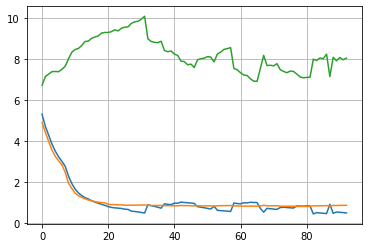

In [ ]:
plt.grid()
plt.plot(losses['train'])
plt.plot(losses['valid'])
plt.plot(losses['hard_valid'])

По итогу на моей "честной" валидации расстояние Ливенштейна ~ 13, на кегле 17 (почему так не разобрался, сплитил всегда с одим сидом на трейнт и тест)

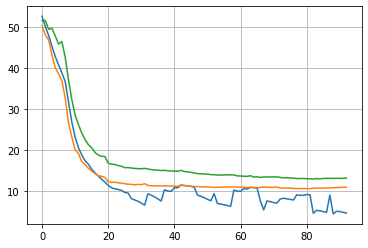

In [ ]:
plt.grid()
plt.plot(lev_distance['train'])
plt.plot(lev_distance['valid'])
plt.plot(lev_distance['hard_valid'])

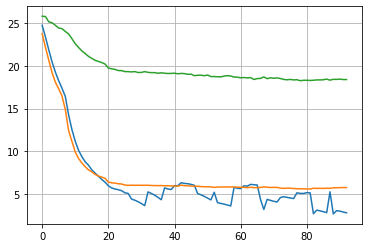

In [ ]:
plt.grid()
plt.plot(symbol_errors['train'])
plt.plot(symbol_errors['valid'])
plt.plot(symbol_errors['hard_valid'])

In [ ]:
it = iter(valid_loader)

In [ ]:
batch = next(it)

In [ ]:
model.eval()
tensor, indexes, tensor_len, indexes_len = batch
batch_size = tensor.size(0)
tensor = tensor.to(device)
indexes = indexes.to(device)
tensor_len = torch.Tensor(tensor_len).to(device)
target = indexes[:, 1:]
logit = logit = model(tensor, tensor_len, None, None, 'valid', max_len)
y_hat = logit.max(-1)[1]

In [ ]:
tr = [int(i) for i in target[5].cpu().numpy()]
tr = tr[:tr.index(eos_id)]
str_target = tokenizer.decode_ids(tr)
pr = [int(i) for i in y_hat[5].cpu().numpy()]
pr = pr[:pr.index(eos_id)]
str_predict = tokenizer.decode_ids(pr)

In [ ]:
str_target

In [ ]:
str_predict

инференс

In [ ]:
class test_SpectrogramDataset(Dataset):
    def __init__(self, data_folder: str, data_list: dict, audio_load_config: set, mespectr_config: set, 
           stats: dict = None) -> None:
        super(test_SpectrogramDataset, self).__init__()
        self.data_folder = data_folder
        self.data_list = data_list
        self.size = len(self.data_list)
        self.audio_load_config = audio_load_config
        self.melspectr = MelSpectrogram(**mespectr_config)
        self.stats = stats

            
    def __getitem__(self, index: int) -> Tuple[Tensor, Tensor]:
        wav_name = self.data_list[index]['wav']
        audio_path = os.path.join(self.data_folder, wav_name)
        spect = self.parse_audio(audio_path)
        return spect
    
    def parse_audio(self, audio_path: str) -> Tensor:
        audio, sr = torchaudio.load(audio_path, **self.audio_load_config)
        spect = self.melspectr(audio.to(torch.FloatTensor()))
        spect = torch.log1p(spect)
        if self.stats is not None:
            spect -= self.stats['mean']
            spect /= self.stats['std']
        return spect
    

    def __len__(self) -> int:
        return self.size
    
  
def _collate_fn(batch):
    def seq_length_(p):
        return p[0].size(1)
    
    seq_lengths = [l.size(2) for l in batch]
    true_pos = np.argsort(np.array(seq_lengths))[::-1]
    batch = sorted(batch, key=lambda sample: sample.size(2), reverse=True) # сортировка для упаковки rnn 
    seq_lengths = [s.size(2) for s in batch]
    max_seq_size = max(seq_lengths)
    feat_size = batch[0].size(1)

    batch_size = len(batch)

    seqs = torch.zeros(batch_size, 1, feat_size, max_seq_size)

    
    for i in range(batch_size):
        seqs[i][:, :, :seq_lengths[i]] = batch[i]
    return seqs, seq_lengths, true_pos

class test_AudioDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(test_AudioDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn
        
        
        
class test_BucketingSampler(Sampler):
    def __init__(self, data_source, batch_size=1):
        super(test_BucketingSampler, self).__init__(data_source)
        self.data_source = data_source
        ids = list(range(0, len(data_source)))
        self.bins = [ids[i:i + batch_size] for i in range(0, len(ids), batch_size)]

        
    def __iter__(self):
        for ids in self.bins:
            yield ids

    def __len__(self):
        return len(self.bins)

    def shuffle(self, epoch):
        pass

In [ ]:
test_folder = 'data/data/test_wavs'
data_test = [{'wav':str(i) + '.wav'} for i in df_test.index.values]
batch_size = 16
test_dataset = test_SpectrogramDataset(test_folder, data_test, audio_load_config, mespectr_config, 
                                       stats = my_stats)
test_sampler = test_BucketingSampler(test_dataset, batch_size=batch_size)
test_loader = test_AudioDataLoader(test_dataset, batch_sampler=test_sampler)

In [ ]:
def decod(y_pred, eos_id, sort_pos, len_X):
    batch_size = y_pred.size(0)
    
    re_sort = torch.zeros_like(y_pred)
    re_len_X = torch.zeros_like(len_X)
    for i, pos in enumerate(sort_pos):
        re_sort[pos] = y_pred[i]
        re_len_X[pos] = len_X[i]
    all_string = []
    for i, sample in enumerate(re_sort):
        sample = sample.tolist()
        try:
            sample = sample[:sample.index(eos_id) + 1]
        except:
            sample = sample[:int(re_len_X[i] / 3)]
        
        all_string.append(tokenizer.decode_ids(sample))
    
    return all_string

In [ ]:
model.eval()
inference = []
pbar = tqdm(iter(test_loader), leave = True, total=len(test_loader))        
for j, batch in enumerate(pbar):
    X, len_X, sort_pos = batch
    X = X.to(device)
    len_X = torch.Tensor(len_X).to(device)
    logit = model(X, len_X, None, None, 'valid', 200)
    y_pred = logit.max(-1)[1] 
    res = decod(y_pred, eos_id, sort_pos, len_X)
    inference += res

In [ ]:
df_test = pd.read_csv('data/data/sample_submission.csv')
df_test.Predicted = inference

In [ ]:
df_test

,Id,Predicted
0,100000,выслов из палабня депитантри владе граф широ в...
1,100001,а списка не нужно зазвучала несколько грубок н...
2,100002,я подумаю что я могу сделать мне поступить шес...
3,100003,я взял еще громче заплакал
4,100004,как нельзя сказать что она свеживает властин р...
...,...,...
19995,119995,я поняла что та жеткая боли была прожжна в пер...
19996,119996,выборни себя что не надела как на конуние соби...
19997,119997,это очень хорошиекурдского орудия
19998,119998,там у него и мать разъесть


In [ ]:
df_test.to_csv('predict.csv', index=False)

In [ ]:
from IPython.display import Audio

Audio(filename='data/data/test_wavs/100035.wav')

In [ ]:
t = df_test.iloc[35]
t.Predicted

'отдадим до сама нашего ордака'